In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import mean_absolute_error,accuracy_score,classification_report,precision_recall_fscore_support, confusion_matrix,r2_score,mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler  
from sklearn.pipeline import Pipeline
import pickle
import seaborn as sns



## Data reading

In [107]:
data = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
data.head()    


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print(data.shape)  
print(data.dtypes)
print(data.isnull().sum())

(16719, 16)
Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score         float64
User_Count         float64
Developer           object
Rating              object
dtype: object
Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         9129
User_Count         9129
Developer          6623
Rating             6769
dtype: int64


In [108]:

numerical_columns = data.select_dtypes('float64').columns
categorical_columns = data.select_dtypes('object').columns
print(numerical_columns.values)
print(numerical_columns.values)

['Year_of_Release' 'NA_Sales' 'EU_Sales' 'JP_Sales' 'Other_Sales'
 'Global_Sales' 'Critic_Score' 'Critic_Count' 'User_Score' 'User_Count']
['Year_of_Release' 'NA_Sales' 'EU_Sales' 'JP_Sales' 'Other_Sales'
 'Global_Sales' 'Critic_Score' 'Critic_Count' 'User_Score' 'User_Count']


### Üresek eltávolítása

In [109]:
cols_to_replace = ['Publisher', 'Developer','Name']
for column in cols_to_replace:
    data[column].fillna('Unknown', inplace=True)

In [110]:
#regi jatekok altalaban nem ertekeltek
data['Critic_Count'] = data['Critic_Count'].fillna(1)
data['User_Count'] = data['User_Count'].fillna(1)

In [111]:
from sklearn.impute import KNNImputer
columns_with_missing = ['User_Score', 'Critic_Score','Year_of_Release']
imputer = KNNImputer(n_neighbors=5)
data[columns_with_missing] = imputer.fit_transform(data[columns_with_missing])

In [112]:
#lehet hogy nagyon rossz ötlet
#helyette
data.dropna(subset=['Rating'], inplace=True)
# for index, row in data.iterrows():
#     year = row['Year_of_Release']
#     genre = row['Genre']
#     if pd.isnull(row['Rating']):
#         if year >= 2010 and genre in ['Action', 'Adventure']:
#             data.at[index, 'Rating'] = 'T'
#         elif year < 2010 and genre in ['Action', 'Adventure']:
#             data.at[index, 'Rating'] = 'M'
#         elif genre in ['Sports', 'Racing']:
#             data.at[index, 'Rating'] = 'E'
#         else:
#             data.at[index, 'Rating'] = 'E10+'


In [113]:
data.dropna(subset=['Genre'], inplace=True)

In [114]:
print(data.isnull().sum())
print(data.shape)

Name               0
Platform           0
Year_of_Release    0
Genre              0
Publisher          0
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
Global_Sales       0
Critic_Score       0
Critic_Count       0
User_Score         0
User_Count         0
Developer          0
Rating             0
dtype: int64
(9950, 16)


In [115]:

data['Year_of_Release'] = data['Year_of_Release'].astype(int)
data['User_Count'] = data['User_Count'].astype(int)
data['Critic_Count'] = data['Critic_Count'].astype(int)
data['Critic_Score'] = data['Critic_Score'].astype(int)

data['User_Score'] = (data['User_Score'] * 10).astype(int)

columns_to_convert = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
data[columns_to_convert] = (data[columns_to_convert] * 100).astype(int)


In [13]:
data[numerical_columns]

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
0,2006,4136,2896,377,844,8253,76,51,80,322
2,2008,1568,1276,379,329,3552,82,73,83,709
3,2009,1561,1093,328,295,3277,80,73,80,192
6,2006,1128,914,650,288,2980,89,65,85,431
7,2006,1396,918,293,284,2892,58,41,66,129
...,...,...,...,...,...,...,...,...,...,...
16701,2003,1,0,0,0,1,53,4,78,1
16702,2008,1,0,0,0,1,48,10,72,1
16706,2011,0,1,0,0,1,60,12,72,13
16708,2008,1,0,0,0,1,66,1,69,1


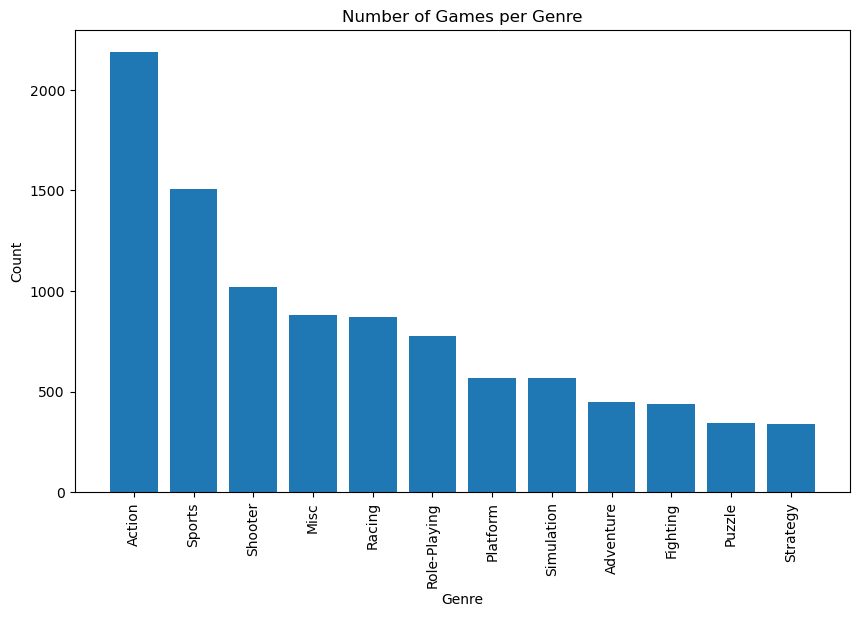

In [14]:
genre_counts = data['Genre'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Number of Games per Genre')
plt.xticks(rotation=90)
plt.show()

In [117]:
##Name nem kell mert egyéni érték 
data = data.drop(['Name'],axis=1)


In [118]:
numerical_columns = data.select_dtypes('int32').columns
categorical_columns = data.select_dtypes('object').columns
print(numerical_columns)

Index(['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales',
       'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score',
       'User_Count'],
      dtype='object')


## LabelEncoding, normalization, splitting

In [119]:

label_encoders = {}

for column in categorical_columns:
    label_encoder = LabelEncoder()

    encoded_values = label_encoder.fit_transform(data[column].astype(str))
    label_encoders[column] = label_encoder
    data[column] = encoded_values
with open('label_encoders.pkl', 'wb') as file:
   pickle.dump(label_encoders, file)

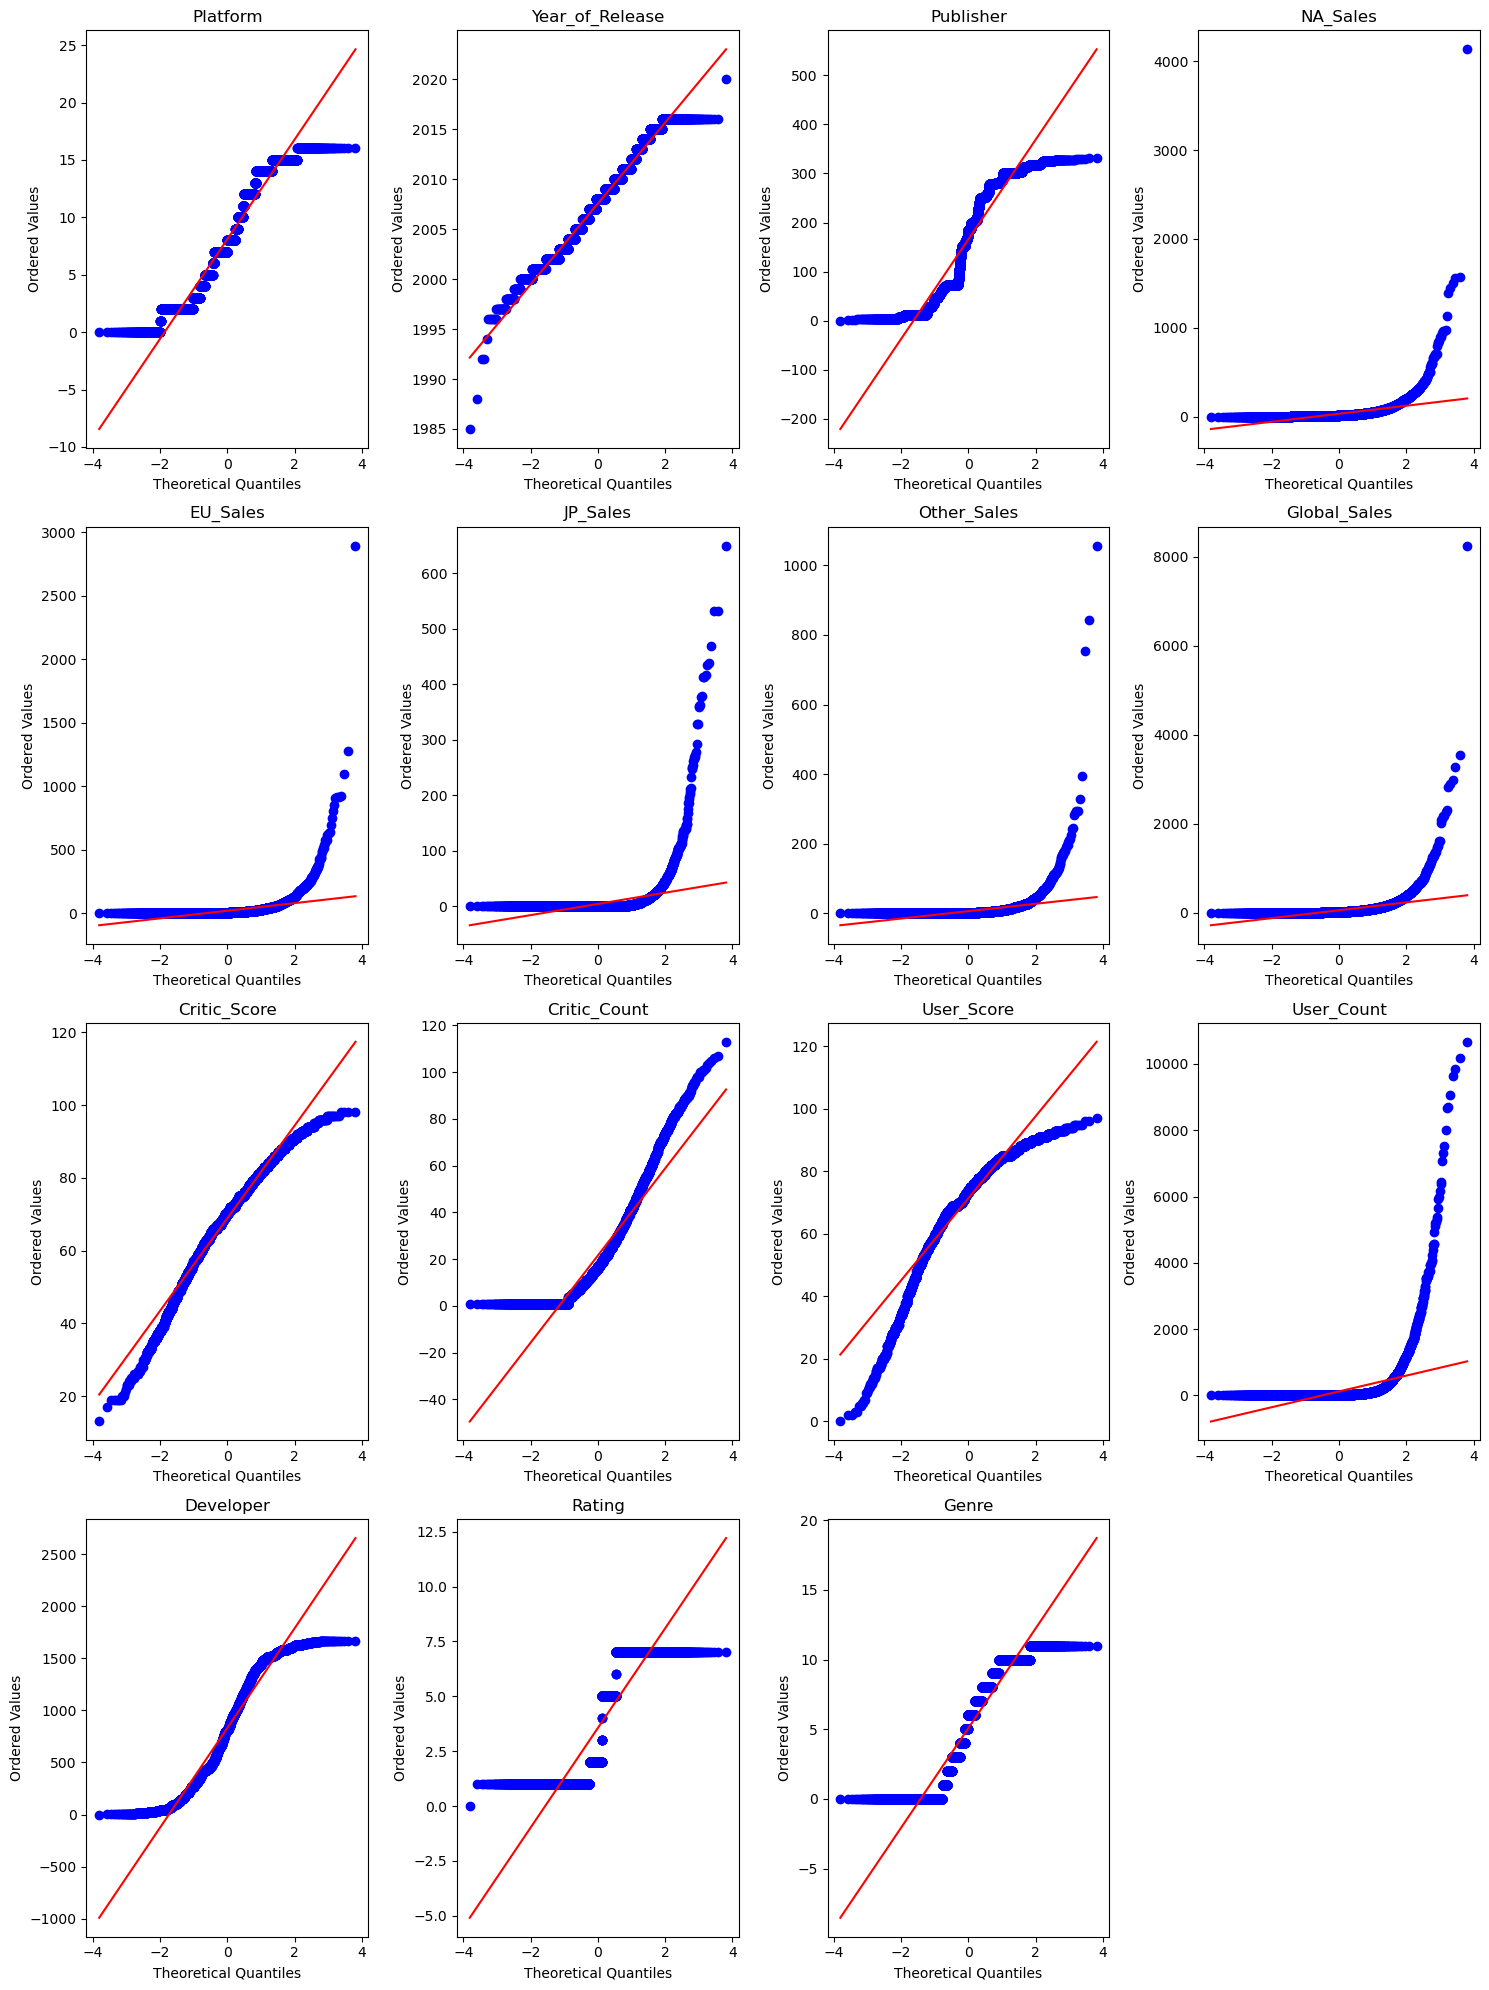

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

columns_to_plot = ["Platform", "Year_of_Release", "Publisher", "NA_Sales", "EU_Sales",
                   "JP_Sales", "Other_Sales", "Global_Sales", "Critic_Score",
                   "Critic_Count", "User_Score", "User_Count", "Developer", "Rating", "Genre"]

num_columns = 4
num_rows = (len(columns_to_plot) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 20))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    color = plt.cm.Set1(i % 14)

    stats.probplot(data[column], plot=axes[i], dist='norm', fit=True)
    axes[i].set_title(column)
    axes[i].set_xlabel("Theoretical Quantiles")
    axes[i].set_ylabel("Ordered Values")

for j in range(len(columns_to_plot), num_rows * num_columns):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.show()


In [ ]:

# Create boxplots for each column
plt.figure(figsize=(12, 8))
sns.boxplot(data=data)
plt.xticks(rotation=90)
plt.title("Boxplot of Columns")
plt.xlabel("Columns")
plt.ylabel("Values")
plt.show()

# Create scatter plots for each column
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data)
plt.xticks(rotation=90)
plt.title("Scatterplot of Columns")
plt.xlabel("Columns")
plt.ylabel("Values")
plt.show()

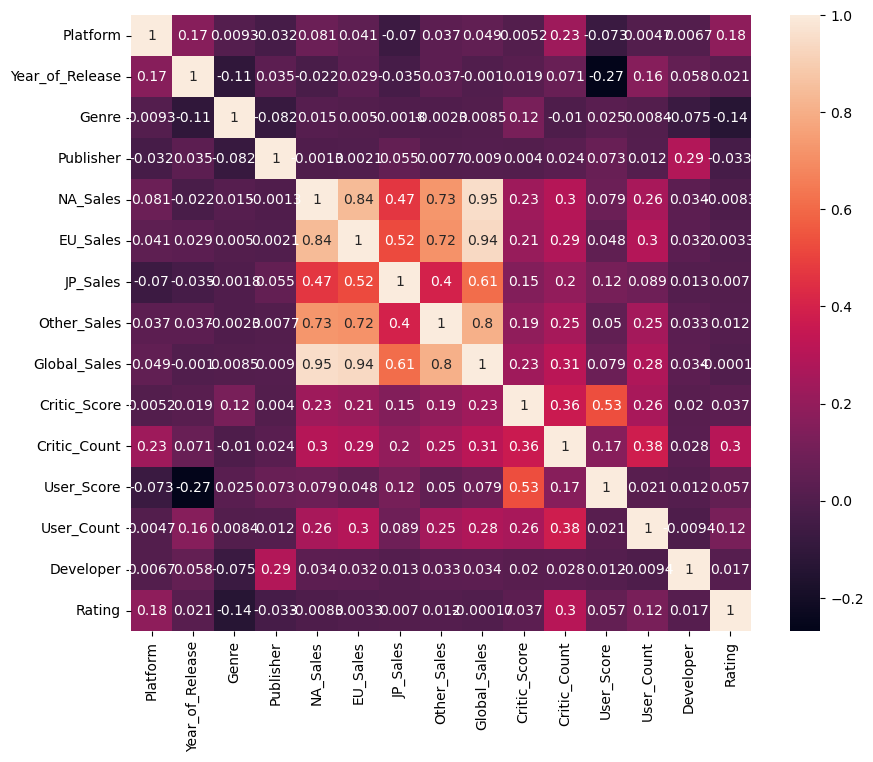

In [19]:
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True) 
plt.show()                            


In [ ]:
print(data.describe())

In [20]:
X = data.drop('Genre', axis=1)
y = data['Genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_test_standard = scaler.transform(X_test)

In [21]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_robust = scaler.fit_transform(X_train)
X_test_robust = scaler.transform(X_test)

## RandomForest

In [120]:
rf_classifier = RandomForestClassifier(max_depth= 18, min_samples_leaf= 1, min_samples_split=6, n_estimators= 763, max_features='log2')

rf_classifier.fit(X_train_robust,y=y_train)
y_pred = rf_classifier.predict(X_test_robust)
rf_accuracy = accuracy_score(y_test,y_pred)
print(rf_accuracy)
print(f'MAE: {mean_absolute_error(y_test,y_pred)}')

with open('pickle/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

0.4809045226130653
MAE: 2.644221105527638


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
rf = RandomForestClassifier()
param_grid = {
    'n_estimators': randint(100, 1000),  
    'max_depth': randint(5, 20),         
    'min_samples_split': randint(2, 10),  
    'min_samples_leaf': randint(1, 10),  
    'max_features': ['sqrt', 'log2']      
}
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=5)
random_search.fit(X_train, y_train)

random_best_params = random_search.best_params_
random_best_score = random_search.best_score_

print(random_best_params)

In [ ]:
random_rf_classifier = RandomForestClassifier(**random_best_params)
random_rf_classifier.fit(X_train, y_train)

y_pred_random = random_rf_classifier.predict(X_test)
print('Accuracy Random Search: ',accuracy_score(y_test, y_pred_random))

## SVM

In [121]:
svm = SVC(kernel='rbf',gamma=0.1,C=1)
svm.fit(X_train_robust,y_train)
y_pred = svm.predict(X_test_robust)
svc_accuracy = accuracy_score(y_test,y_pred)
print(svc_accuracy)
print(f'MAE: {mean_absolute_error(y_test,y_pred)}')

with open('pickle/svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)

0.3331658291457286
MAE: 3.744723618090452


In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': [ 'rbf','sigmoid','poly'],
    'gamma': [0.1, 1, 10]
}
svm_classifier = SVC()
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

In [ ]:

svm = SVC(**best_params)
svm.fit(X_train, y_train)


y_pred = svm.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print('Accuracy: ',accuracy_score(y_test,y_pred))

## LogisticRegression 

In [125]:
X_train=X_train_robust
X_test=X_test_robust
lr = LogisticRegression(C=10,penalty='l2',solver='liblinear',max_iter=400)
lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", lr_accuracy)
print(f'MAE: {mean_absolute_error(y_test,y_pred)}')

with open('pickle/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(lr, f)


Accuracy: 0.3
MAE: 3.915577889447236


In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

logistic_classifier = LogisticRegression()

grid_search = GridSearchCV(logistic_classifier, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

In [ ]:
best_logistic_classifier = LogisticRegression(**best_params)
best_logistic_classifier.fit(X_train, y_train)

y_pred = best_logistic_classifier.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

## Voting

In [122]:
X_test=X_test_robust
X_train=X_train_robust
rf = rf_classifier

svc = svm



voting_classifier = VotingClassifier(
    estimators=[('svc', svc), ('rf', rf), ('lr', lr)],
    voting='hard'
)

voting_classifier.fit(X_train, y_train)

y_pred = voting_classifier.predict(X_test)
y_pred = voting_classifier.predict(X_test)
voting_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", voting_accuracy)
print(f'MAE: {mean_absolute_error(y_test,y_pred)}')

with open('pickle/voting_classifier.pkl', 'wb') as f:
    pickle.dump(voting_classifier, f)

Accuracy: 0.3773869346733668
MAE: 3.499497487437186


## Stacking

In [123]:
from sklearn.ensemble import StackingClassifier
X_test=X_test_robust
X_train=X_train_robust
rf = rf_classifier

svc = svm

stacking_classifier = StackingClassifier(
    estimators=[('svc', svc), ('lr', lr)],
    final_estimator=rf
)

stacking_classifier.fit(X_train, y_train)

y_pred = stacking_classifier.predict(X_test)

stacking_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", stacking_accuracy)

with open('pickle/stacking_model.pkl', 'wb') as f:
    pickle.dump(stacking_classifier, f)

Accuracy: 0.38894472361809046


## Saját modell

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

In [124]:
X_train_ = X_train_robust
X_test_ = X_test_robust
model = Sequential()
model.add(Dense(2048, activation='relu', input_shape=(X_train_.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))


model.add(Dense(len(y.unique()), activation='softmax'))


learning_rate = 0.0001 
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(patience=20)
history = model.fit(X_train_, y_train, validation_data=(X_test_, y_test),
                    batch_size=128, epochs=200, callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate(X_test_, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

with open('pickle/sajat_model.pkl', 'wb') as f:
    pickle.dump(model, f)

Epoch 1/200
63/63 [==============================] - 4s 43ms/step - loss: 2.5897 - accuracy: 0.1263 - val_loss: 2.4161 - val_accuracy: 0.2201
Epoch 2/200
63/63 [==============================] - 3s 47ms/step - loss: 2.4892 - accuracy: 0.1771 - val_loss: 2.3910 - val_accuracy: 0.2186
Epoch 3/200
63/63 [==============================] - 3s 47ms/step - loss: 2.4614 - accuracy: 0.1985 - val_loss: 2.3571 - val_accuracy: 0.2196
Epoch 4/200
63/63 [==============================] - 3s 44ms/step - loss: 2.4288 - accuracy: 0.2144 - val_loss: 2.3250 - val_accuracy: 0.2307
Epoch 5/200
63/63 [==============================] - 3s 45ms/step - loss: 2.3817 - accuracy: 0.2247 - val_loss: 2.2831 - val_accuracy: 0.2588
Epoch 6/200
63/63 [==============================] - 3s 40ms/step - loss: 2.3454 - accuracy: 0.2340 - val_loss: 2.2383 - val_accuracy: 0.2849
Epoch 7/200
63/63 [==============================] - 3s 40ms/step - loss: 2.3230 - accuracy: 0.2376 - val_loss: 2.2070 - val_accuracy: 0.2829
Epoch 

In [ ]:
# Best Parameters:  {'batch_size': 128, 'epochs': 200, 'learning_rate': 0.0001}
# Best Accuracy:  0.42114709814389545s

## EREDMENYEK

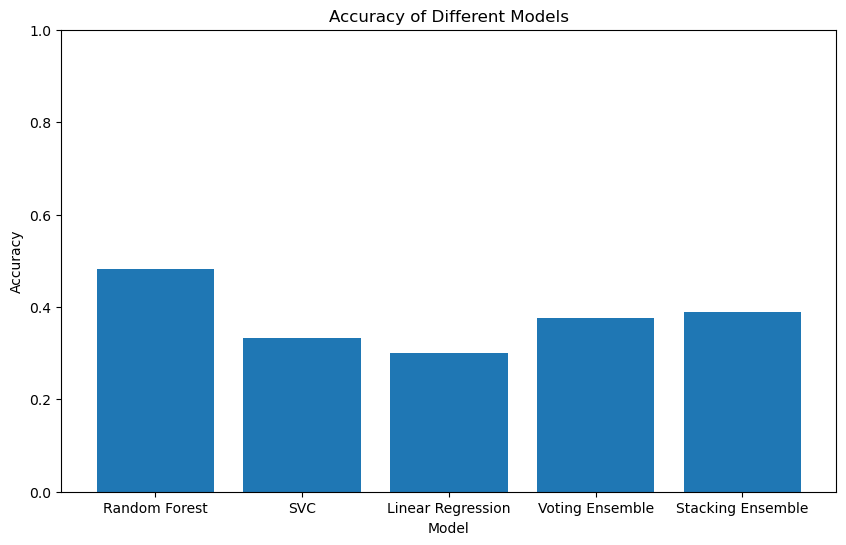

In [106]:


# Accuracy scores for each model
accuracy_scores = [rf_accuracy, svc_accuracy, lr_accuracy,voting_accuracy,stacking_accuracy]

# Model names
model_names = ['Random Forest', 'SVC', 'Linear Regression','Voting Ensemble','Stacking Ensemble']

# Plotting the accuracy scores
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_scores)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0, 1)  # Set the y-axis limits to better visualize accuracy
plt.show()

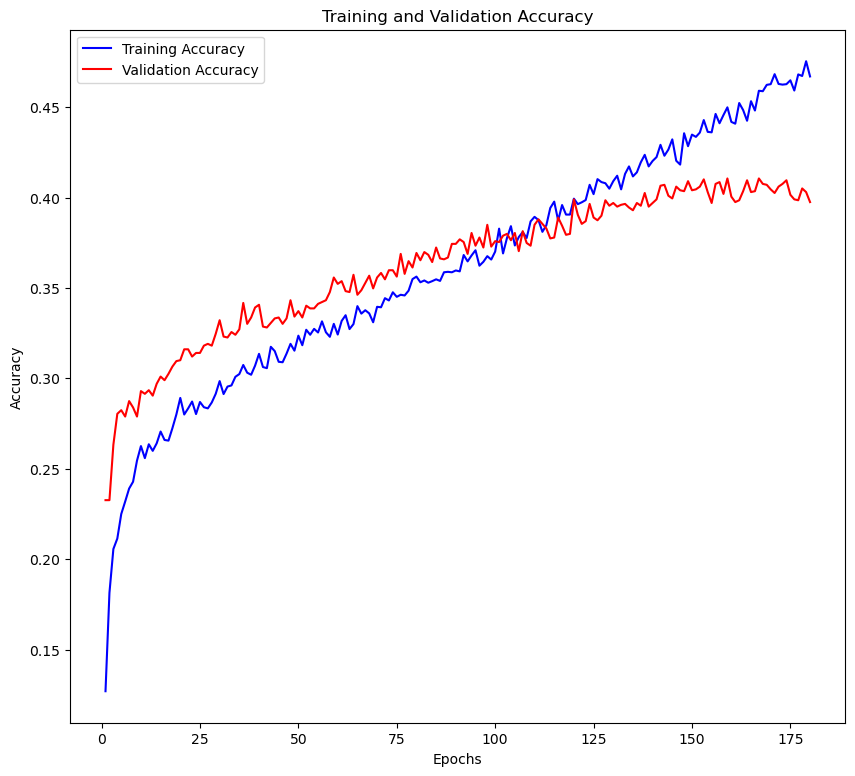

In [102]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(10, 9))
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()